<a href="https://colab.research.google.com/github/sila0/Face-Yaw-Roll-Pitch-from-Pose-Estimation-using-OpenCV/blob/master/stargan_runtime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Stargan V2

In [ ]:
%%capture
import os
os.chdir('/content')

# checkout source
!git clone https://github.com/sila0/stargan-v2.git

# update source
try: 
  os.chdir('/content/stargan-v2')
except FileNotFoundError as e:
  print("dir not found:", e.filename)
  print("current working dir:", os.getcwd())

!git pull

# download data and weight
!bash download.sh wing
!bash download.sh celeba-hq-dataset
!bash download.sh pretrained-network-celeba-hq


# Install pyTorch

In [ ]:
%%capture
!pip install gputil
!pip install -Uqq fastbook==0.0.14 pillow==7.0.0 munch==2.5.0
!pip install opencv-python==4.1.2.30 ffmpeg-python==0.2.0 scikit-image==0.16.2
!pip install facenet_pytorch

# Mount google drive

In [ ]:
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


#Import lib

In [28]:
import cv2, dlib, random, base64, torch, shutil

from os.path import isfile, join
from os import listdir
from io import BytesIO
from glob import glob

from IPython.display import HTML
from PIL import Image, ImageOps

from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
import pandas as pd
import numpy as np

from munch import Munch
from torch.backends import cudnn

import GPUtil as GPU
from facenet_pytorch import MTCNN, InceptionResnetV1
from fastbook import *
from torchvision import transforms

from core.data_loader import get_train_loader
from core.data_loader import get_test_loader
from core.solver import Solver


#Init starGan parameter

In [ ]:
class Args():
  def __init__(self, src=None, ref=None, ref_y=None):
    self.batch_size=8
    self.beta1=0.0
    self.beta2=0.99
    self.checkpoint_dir='/content/drive/MyDrive/checkpoint'
    self.ds_iter=100000
    self.eval_dir='expr/eval'
    self.eval_every=50000
    self.f_lr=1e-06
    self.hidden_dim=512
    self.img_size=256
    self.inp_dir='assets/representative/custom/female'
    self.lambda_cyc=1
    self.lambda_ds=1
    self.lambda_reg=1
    self.lambda_sty=1
    self.latent_dim=16
    self.lm_path='expr/checkpoints/celeba_lm_mean.npz'
    self.lr=0.0001
    self.mode='test'
    self.num_domains=2
    self.num_outs_per_domain=10
    self.num_workers=4
    self.out_dir='assets/representative/celeba_hq/src/female'
    self.print_every=10
    self.randcrop_prob=0.5
    self.ref_dir='assets/representative/celeba_hq/ref'
    self.result_dir='expr/results'
    self.resume_iter=59000
    self.sample_dir='expr/samples'
    self.sample_every=5000
    self.save_every=10000
    self.seed=777
    self.src_dir='assets/representative/celeba_hq/src'
    self.style_dim=64
    self.total_iters=100000
    self.train_img_dir='data/celeba_hq/train'
    self.val_batch_size=32
    self.val_img_dir='data/celeba_hq/val'
    self.w_hpf=1
    self.weight_decay=0.0001
    self.wing_path='expr/checkpoints/wing.ckpt'
    self.src=src
    self.ref=ref
    self.y_ref=ref_y

ori_args = Args()
ori_args.checkpoint_dir = '/content/stargan-v2/expr/checkpoints/celeba_hq'
ori_args.resume_iter = 100000

new_args = Args()
new_args.resume_iter = 60000


#Init DataFrame


*   male_df
*   female_df



In [ ]:
def make_df(files):
  samples = []
  feature_conf = None

  if 'female' in files[0]:
    feature_conf = (0 , 1)
  else:
    feature_conf = (1 , 0)

  for i in range(sample_number):
    samples.append((random.choice(files), *feature_conf))
    
  df = pd.DataFrame(samples, columns=['path', 'src_y', 'tar_y'])
  df.reset_index(inplace=True)

  return df

In [ ]:
# new_args.resume_iter = 59000
sample_number = 20

female_path = '/content/stargan-v2/data/celeba_hq/val/female'
male_path = '/content/stargan-v2/data/celeba_hq/val/male'

female_files = [join(female_path, f) for f in listdir(female_path) if isfile(join(female_path, f))]
male_files = [join(male_path, f) for f in listdir(male_path) if isfile(join(male_path, f))]

female_df = make_df(female_files)
male_df = make_df(male_files)

print('df shape')
print('male_df:', male_df.shape)
print('female_df:', female_df.shape)

df shape
male_df: (20, 4)
female_df: (20, 4)


#Compute head pose

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/weight/shape_predictor_68_face_landmarks.dat')

def get_xyz(im_path):
  # Read Image
  image = Image.open(im_path[0])
  image = image.resize((256,256))
  gray = ImageOps.grayscale(image)
  
  data = np.asarray(gray)
  rects = detector(data, 1)
  if len(rects) == 0:
    return np.nan, np.nan, np.nan
  shape = predictor(data, rects[0])
  
  dim = (256,256)
  im = cv2.imread(im_path[0])
  im = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)
  size = im.shape
  
  #2D image points. If you change the image, you need to change vector
  image_points = np.array([
                         (shape.part(30).x, shape.part(30).y),     # Nose tip
                         (shape.part(8).x,  shape.part(8).y),      # Chin
                         (shape.part(36).x, shape.part(36).y),     # Left eye left corner
                         (shape.part(45).x, shape.part(45).y),     # Right eye right corne
                         (shape.part(48).x, shape.part(48).y),     # Left Mouth corner
                         (shape.part(54).x, shape.part(54).y)      # Right mouth corner
                         ], dtype="double")
  
  # 3D model points.
  model_points = np.array([
                           (0.0, 0.0, 0.0),             # Nose tip
                           (0.0, -330.0, -65.0),        # Chin
                           (-225.0, 170.0, -135.0),     # Left eye left corner
                           (225.0, 170.0, -135.0),      # Right eye right corne
                           (-150.0, -150.0, -125.0),    # Left Mouth corner
                           (150.0, -150.0, -125.0)      # Right mouth corner
                           ])
  
  # Camera internals
  focal_length = size[1]
  center = (size[1]/2, size[0]/2)
  camera_matrix = np.array(
                          [[focal_length, 0, center[0]],
                          [0, focal_length, center[1]],
                          [0, 0, 1]], dtype = "double"
                          )
  
  # print("Camera Matrix :\n {0}".format(camera_matrix))
  dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
  success, rotation_vector, translation_vector = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)
  mdists = np.zeros((4, 1), dtype=np.float64)
  
  # calculating angle
  rmat, jac = cv2.Rodrigues(rotation_vector)
  angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)
  
  (nose_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)
  for p in image_points:
    cv2.circle(im, (int(p[0]), int(p[1])), 3, (0,0,255), -1)
  
  rvec_matrix = cv2.Rodrigues(rotation_vector)[0]

  proj_matrix = np.hstack((rvec_matrix, translation_vector))

  eulerAngles = cv2.decomposeProjectionMatrix(proj_matrix)[6] 
  
  pitch, yaw, roll = [math.radians(_) for _ in eulerAngles]

  pitch = math.degrees(math.asin(math.sin(pitch)))
  roll = -math.degrees(math.asin(math.sin(roll)))
  yaw = math.degrees(math.asin(math.sin(yaw))) 

  return pitch, roll, yaw


In [ ]:
# cal head pose
male_df[['pitch','roll','yaw']] = male_df.loc[:,['path']].apply(get_xyz, axis=1, result_type="expand")
female_df[['pitch','roll','yaw']] = female_df.loc[:,['path']].apply(get_xyz, axis=1, result_type="expand")

print('df shape, male:', male_df.shape)
print('df shape, female:', female_df.shape)

df shape, male: (20, 7)
df shape, female: (20, 7)


#Find best match headpose image
find best match by using cosine similarity on head pose

In [ ]:
def best_pose_match(row, df):
  scores = []
  selected_cols = ['pitch', 'roll', 'yaw']
  for _, row_b in df.loc[:,selected_cols].iterrows():
    score = 1 - cosine(row.values, row_b.values)
    scores.append(score)

  df['score'] = pd.Series(scores, index=df.index)

  return df.sort_values(by=['score'], ascending=False).iloc[0,:].path

In [ ]:
ref_paths = []
selected_cols = ['pitch', 'roll', 'yaw']

for _, row in male_df.loc[:,selected_cols].iterrows():
  ref_paths.append(best_pose_match(row, female_df))

male_df.loc[:,'ref_path'] = pd.Series(ref_paths, index=male_df.index)


#Show selected images

In [ ]:
def get_thumbnail(path):
    i = Image.open(path)  
    i = i.resize((160,160))  
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'



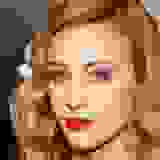

In [29]:
thumb = get_thumbnail('/content/stargan-v2/data/celeba_hq/val/female/087247.jpg')
HTML(image_formatter(thumb))

,index,path,src_y,tar_y,pitch,roll,yaw,ref_path,src_image,ref_image
0,0,/content/stargan-v2/data/celeba_hq/val/male/086669.jpg,1,0,2.194287,-1.831172,-11.737161,/content/stargan-v2/data/celeba_hq/val/female/055731.jpg,,
1,1,/content/stargan-v2/data/celeba_hq/val/male/097420.jpg,1,0,7.181043,0.657002,4.129062,/content/stargan-v2/data/celeba_hq/val/female/147434.jpg,,
2,2,/content/stargan-v2/data/celeba_hq/val/male/045910.jpg,1,0,4.071541,0.822763,5.613308,/content/stargan-v2/data/celeba_hq/val/female/131404.jpg,,
3,3,/content/stargan-v2/data/celeba_hq/val/male/008966.jpg,1,0,-10.466709,-0.401603,-17.791910,/content/stargan-v2/data/celeba_hq/val/female/164999.jpg,,
4,4,/content/stargan-v2/data/celeba_hq/val/male/007143.jpg,1,0,5.080215,3.491647,17.939072,/content/stargan-v2/data/celeba_hq/val/female/092801.jpg,,
5,5,/content/stargan-v2/data/celeba_hq/val/male/061172.jpg,1,0,-1.511939,0.642945,9.811624,/content/stargan-v2/data/celeba_hq/val/female/090393.jpg,,
6,6,/content/stargan-v2/data/celeba_hq/val/male/199771.jpg,1,0,-1.603018,0.107512,-9.637009,/content/stargan-v2/data/celeba_hq/val/female/087217.jpg,,
7,7,/content/stargan-v2/data/celeba_hq/val/male/155386.jpg,1,0,1.870924,0.602954,0.725226,/content/stargan-v2/data/celeba_hq/val/female/147434.jpg,,
8,8,/content/stargan-v2/data/celeba_hq/val/male/070654.jpg,1,0,-0.444225,0.340424,2.484219,/content/stargan-v2/data/celeba_hq/val/female/090393.jpg,,
9,9,/content/stargan-v2/data/celeba_hq/val/male/073717.jpg,1,0,10.594816,6.355794,28.114206,/content/stargan-v2/data/celeba_hq/val/female/092801.jpg,,

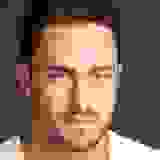
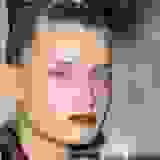
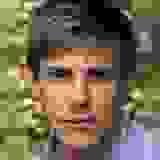
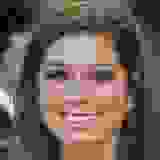
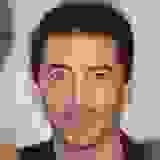
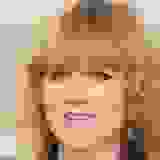
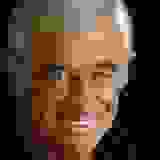
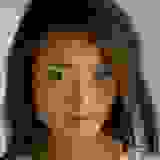
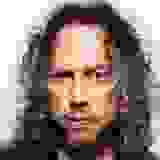
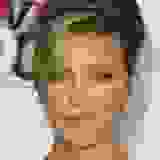
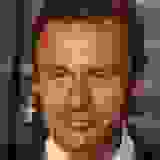
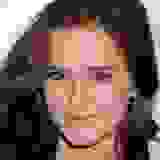
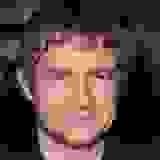
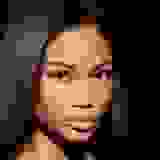
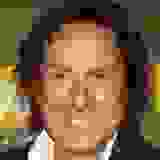
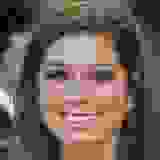
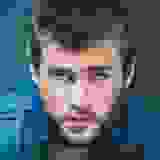
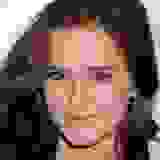
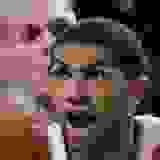
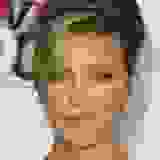
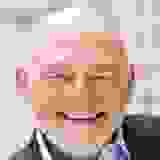
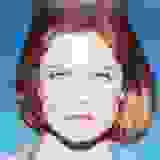
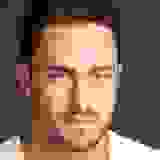
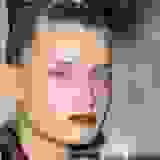
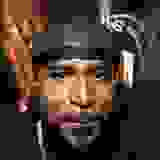
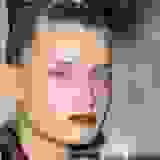
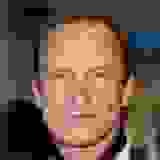
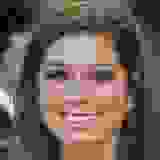
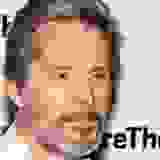
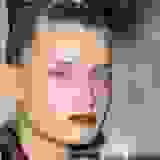
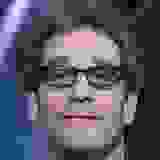
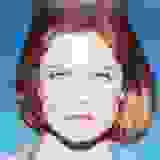
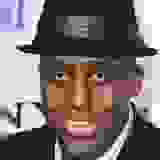
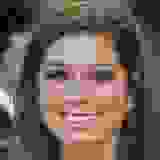
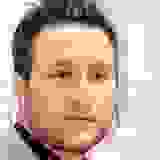
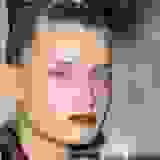
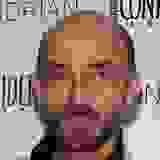
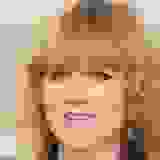
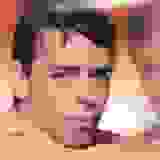
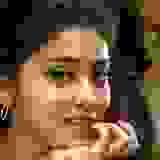

In [ ]:
male_df['src_image'] = male_df.path.map(lambda f: get_thumbnail(f))
male_df['ref_image'] = male_df.ref_path.map(lambda f: get_thumbnail(f))

HTML(male_df.to_html(
    formatters={
        'src_image': image_formatter,
        'ref_image': image_formatter
        }, 
    escape=False))

#Generate Image

In [ ]:
def generate_image(solver, solver_args, row, pref=None):
  solver_args.src = row.path
  solver_args.ref = row.ref_path
  solver_args.y_ref = row.tar_y

  tmp = str(random.randint(10000, 99999))
  filename = pref + tmp
  
  return solver.test(solver_args, filename)

In [ ]:
%%capture
# base image
base_args = Args()
base_args.checkpoint_dir = '/content/stargan-v2/expr/checkpoints/celeba_hq'
base_args.resume_iter = 100000
base_solver = Solver(base_args)
cwd = os.getcwd()

paths = []

for _, row in male_df.iterrows():
  
  paths.append(
      os.path.join(
          cwd, 
          generate_image(base_solver, base_args, row, 'base_')
          )
      )


male_df.loc[:,'base_path'] = pd.Series(paths, index=male_df.index)

In [ ]:
%%capture
# our image
our_args = Args()
our_args.resume_iter = 60000
our_solver = Solver(our_args)
cwd = os.getcwd()

paths = []

for _, row in male_df.iterrows():
  
  paths.append(
      os.path.join(
          cwd, 
          generate_image(our_solver, our_args, row, 'our_')
          )
      )


male_df.loc[:,'our_path'] = pd.Series(paths, index=male_df.index)

#Reorder df column & Display

,index,path,src_y,tar_y,pitch,roll,yaw,ref_path,our_path,base_path,src_image,ref_image,our_image,base_image
0,0,/content/stargan-v2/data/celeba_hq/val/male/093786.jpg,1,0,11.442994,1.760727,7.505907,/content/stargan-v2/data/celeba_hq/val/female/148457.jpg,/content/stargan-v2/our_44795.jpg,/content/stargan-v2/base_38016.jpg,,,,
1,1,/content/stargan-v2/data/celeba_hq/val/male/053285.jpg,1,0,-5.856234,0.597591,-2.675910,/content/stargan-v2/data/celeba_hq/val/female/122646.jpg,/content/stargan-v2/our_15014.jpg,/content/stargan-v2/base_62565.jpg,,,,
2,2,/content/stargan-v2/data/celeba_hq/val/male/155697.jpg,1,0,8.168878,0.190952,2.914421,/content/stargan-v2/data/celeba_hq/val/female/009737.jpg,/content/stargan-v2/our_24208.jpg,/content/stargan-v2/base_17685.jpg,,,,
3,3,/content/stargan-v2/data/celeba_hq/val/male/048587.jpg,1,0,6.047217,0.528575,3.824271,/content/stargan-v2/data/celeba_hq/val/female/148457.jpg,/content/stargan-v2/our_88193.jpg,/content/stargan-v2/base_31579.jpg,,,,
4,4,/content/stargan-v2/data/celeba_hq/val/male/099328.jpg,1,0,3.037343,0.169035,15.578941,/content/stargan-v2/data/celeba_hq/val/female/002475.jpg,/content/stargan-v2/our_66959.jpg,/content/stargan-v2/base_59672.jpg,,,,
5,5,/content/stargan-v2/data/celeba_hq/val/male/000406.jpg,1,0,9.022023,-2.816325,-13.193411,/content/stargan-v2/data/celeba_hq/val/female/012608.jpg,/content/stargan-v2/our_55309.jpg,/content/stargan-v2/base_10282.jpg,,,,
6,6,/content/stargan-v2/data/celeba_hq/val/male/122610.jpg,1,0,20.778896,-1.077112,-5.905000,/content/stargan-v2/data/celeba_hq/val/female/025396.jpg,/content/stargan-v2/our_51114.jpg,/content/stargan-v2/base_61173.jpg,,,,
7,7,/content/stargan-v2/data/celeba_hq/val/male/169375.jpg,1,0,-3.589849,-2.749401,-6.369783,/content/stargan-v2/data/celeba_hq/val/female/004892.jpg,/content/stargan-v2/our_67199.jpg,/content/stargan-v2/base_44760.jpg,,,,
8,8,/content/stargan-v2/data/celeba_hq/val/male/007033.jpg,1,0,-0.898292,2.415108,22.111683,/content/stargan-v2/data/celeba_hq/val/female/070708.jpg,/content/stargan-v2/our_89457.jpg,/content/stargan-v2/base_69638.jpg,,,,
9,9,/content/stargan-v2/data/celeba_hq/val/male/018765.jpg,1,0,11.146006,-1.322606,-3.394367,/content/stargan-v2/data/celeba_hq/val/female/025396.jpg,/content/stargan-v2/our_77033.jpg,/content/stargan-v2/base_47388.jpg,,,,

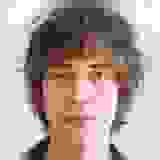
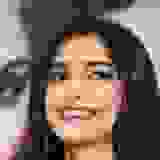
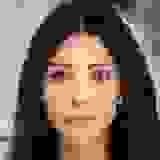
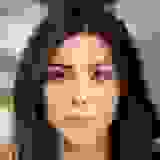
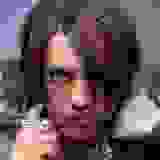
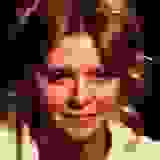
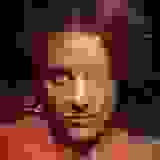
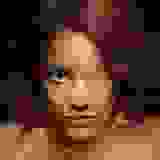
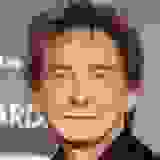
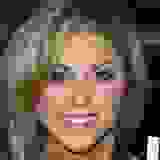
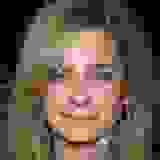
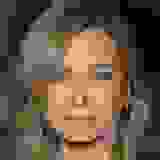
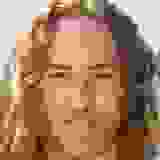
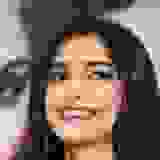
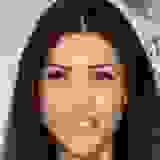
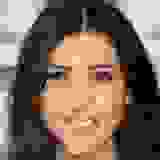
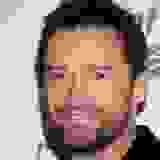
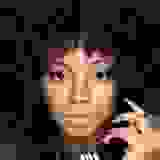
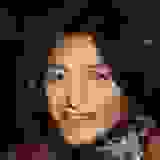
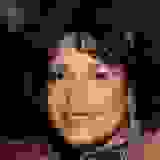
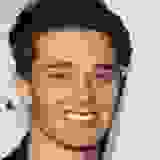
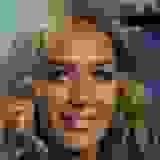
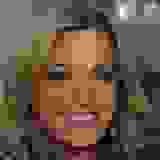
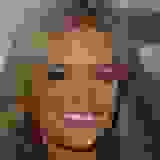
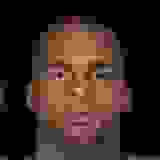
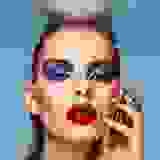
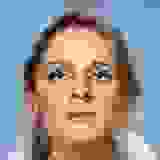
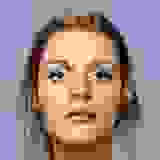
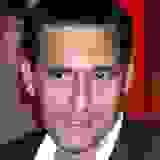
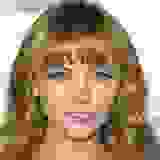
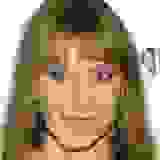
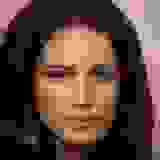
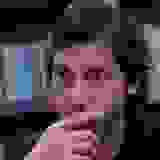
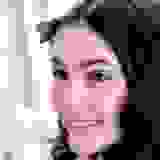
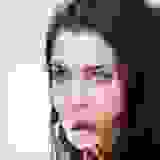
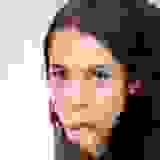
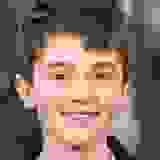
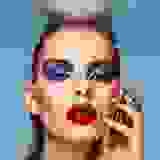
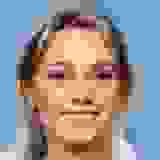
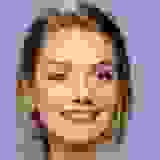
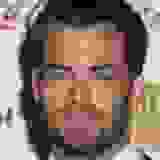
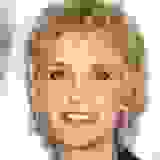
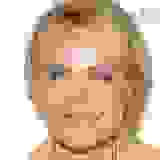
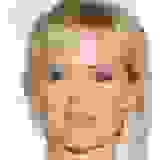
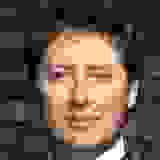
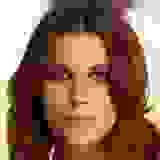
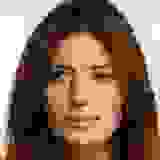
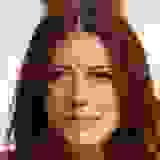
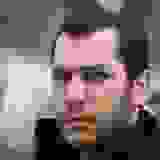
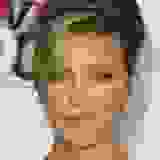
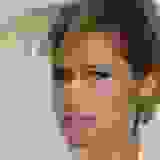
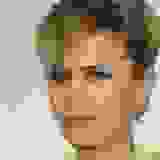
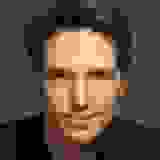
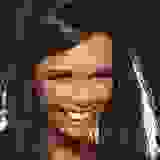
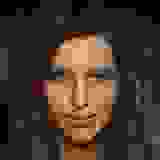
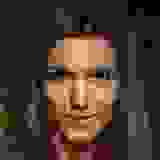
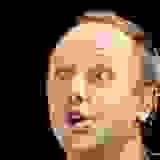
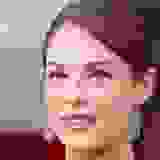
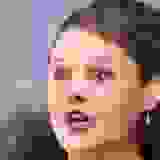
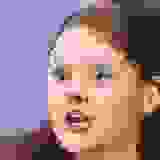
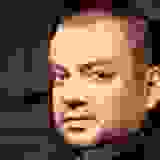
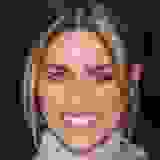
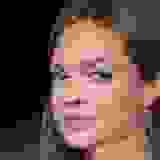
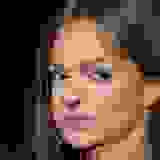
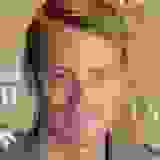
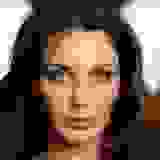
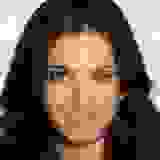
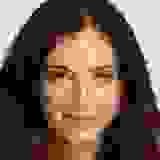
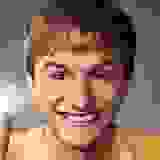
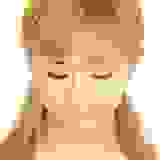
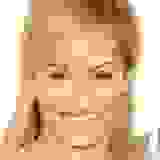
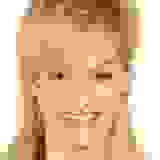
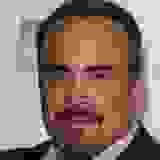
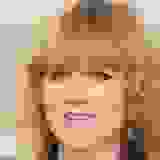
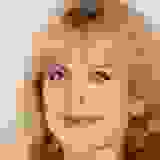
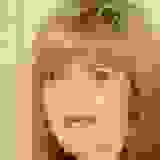
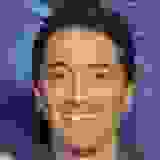
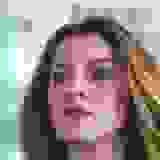
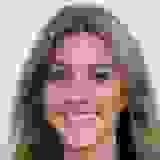
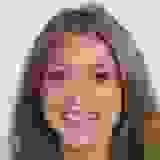
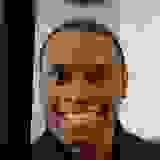
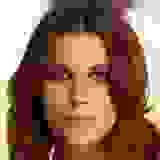
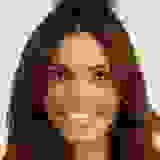
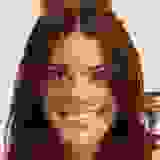
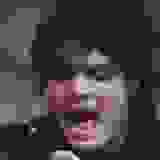
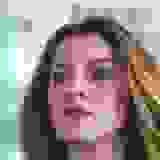
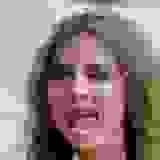
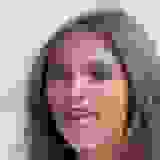
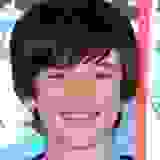
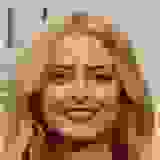
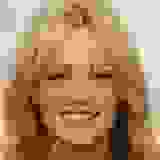
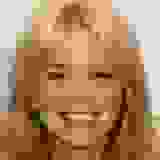
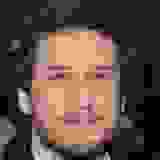
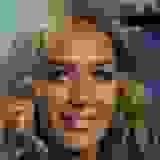
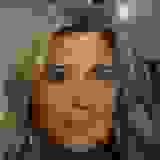
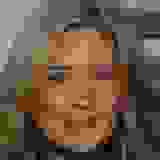
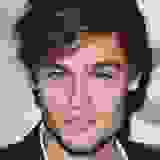
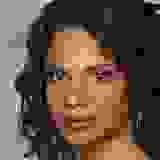
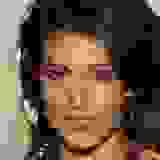
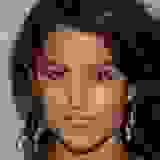
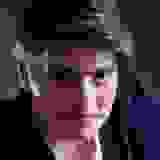
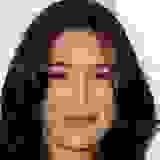
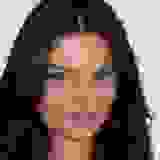
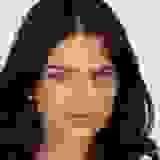
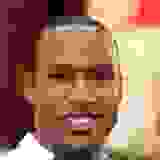
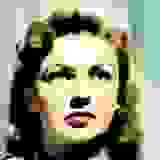
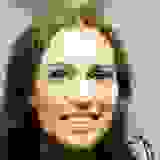
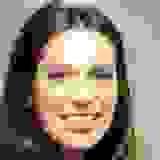
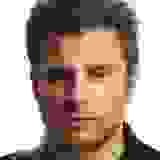
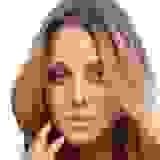
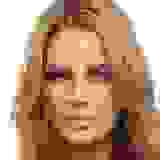
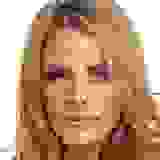
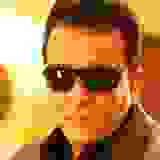
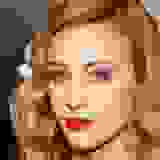
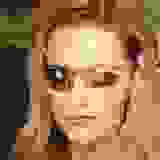
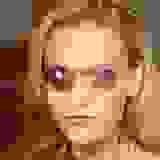
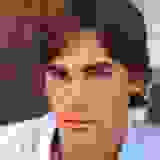
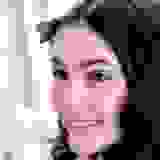
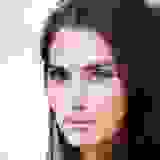
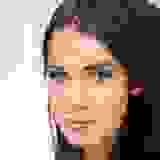
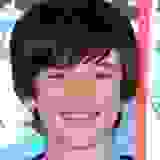
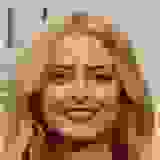
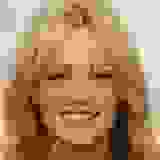
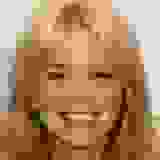
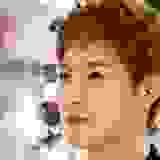
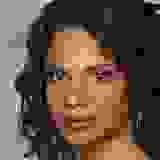
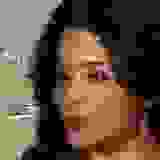
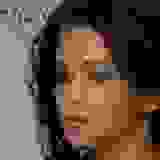
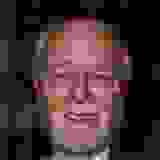
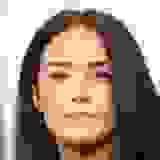
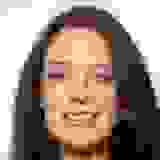
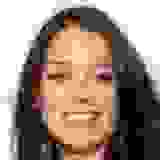
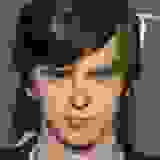
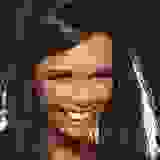
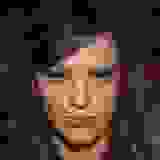
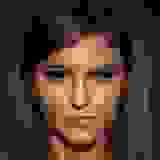
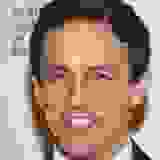
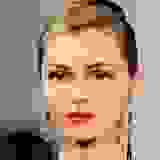
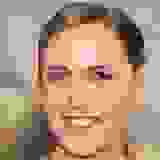
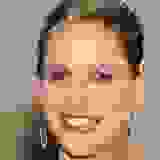
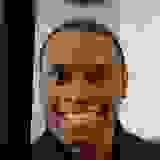
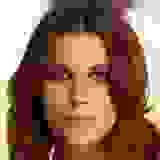
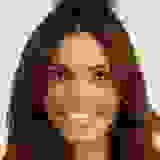
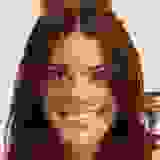
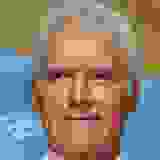
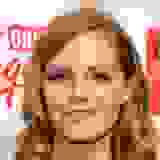
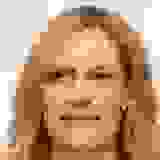
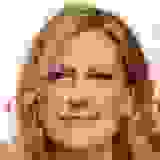
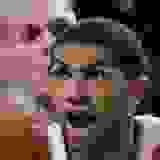
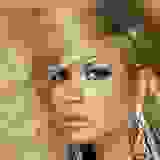
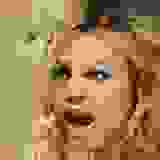
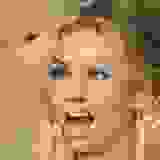
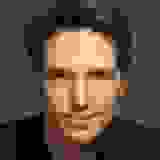
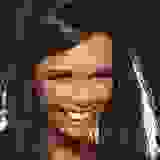
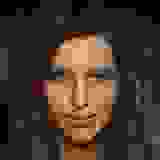
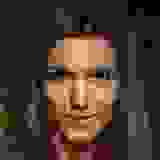
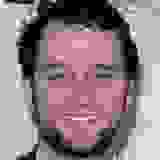
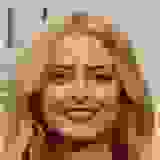
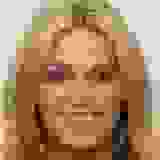
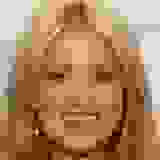
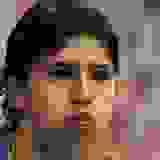
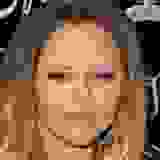
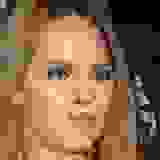
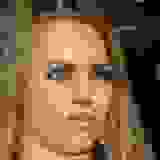
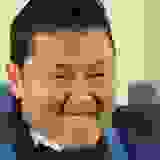
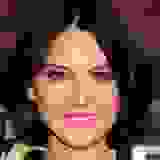
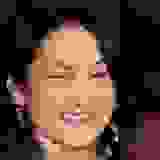
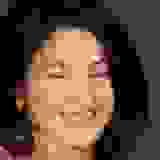
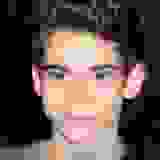
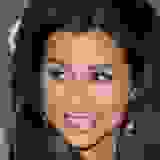
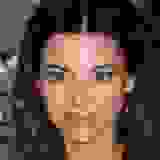
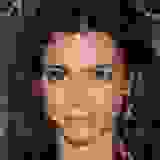
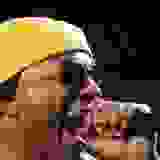
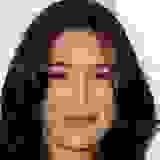
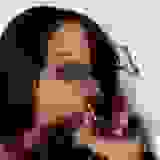
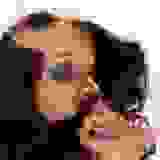
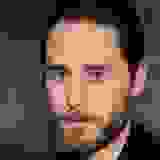
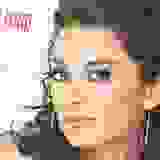
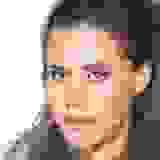
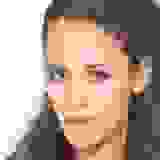
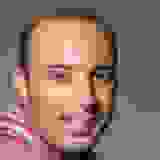
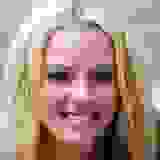
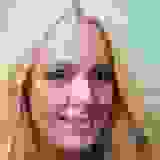
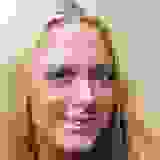
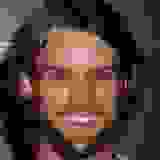
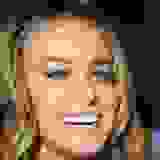
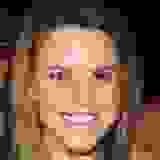
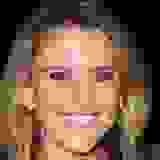
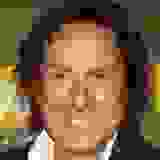
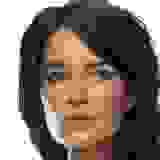
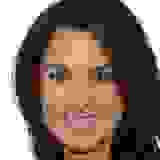
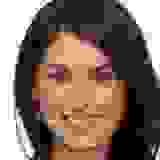
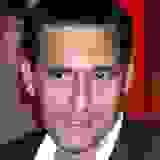
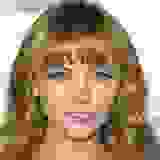
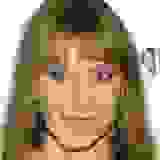
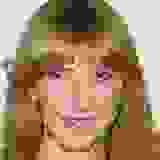
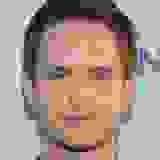
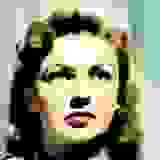
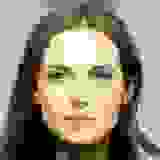
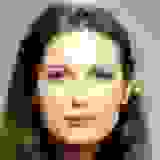
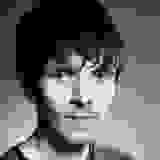
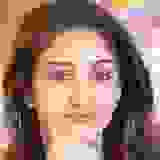
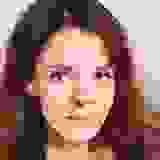
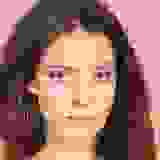
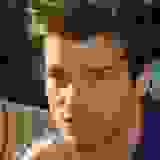
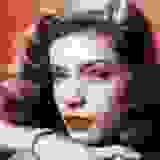
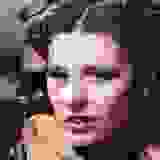
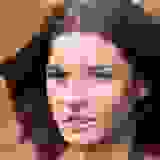
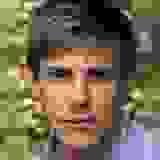
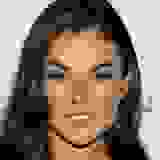
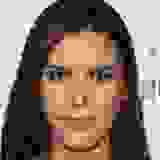
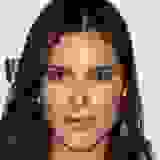
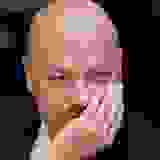
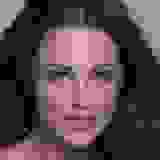
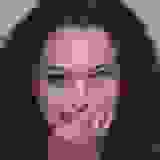
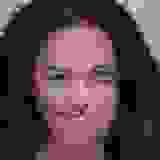
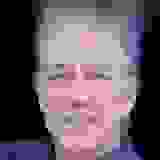
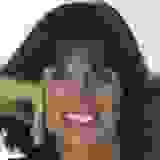
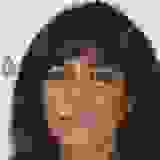
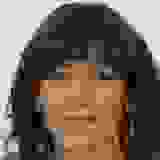
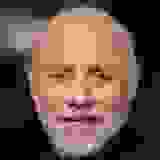
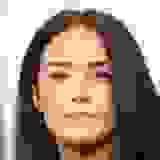
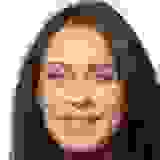
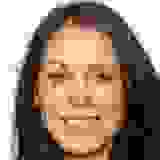
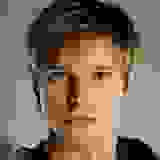
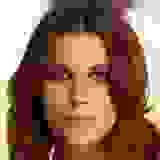
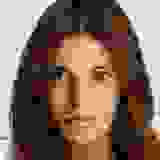
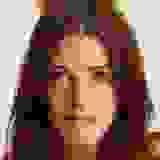
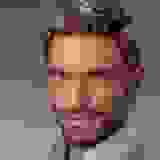
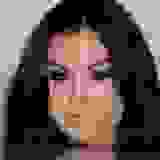
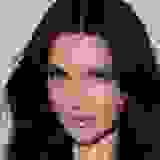
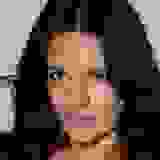
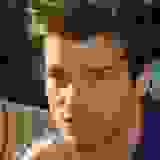
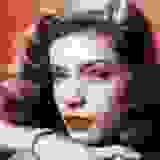
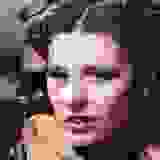
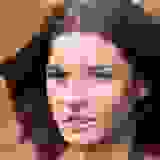
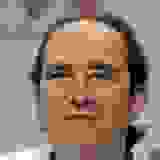
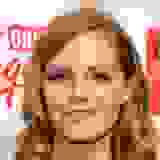
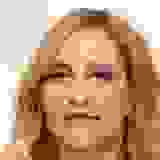
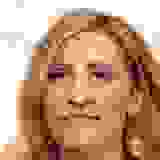
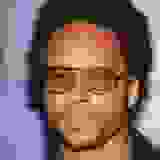
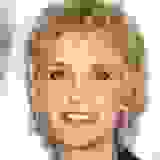
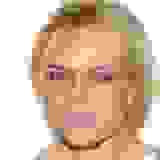
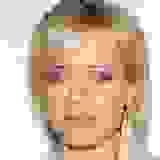
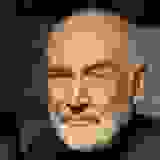
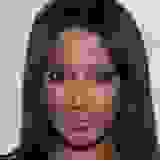
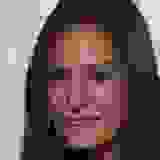
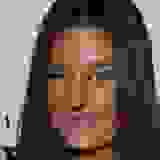
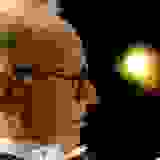
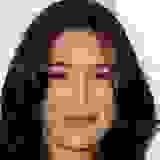
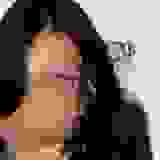
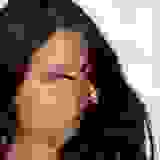
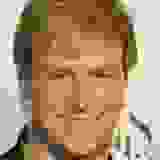
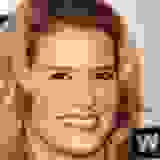
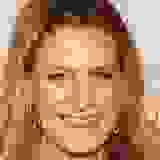
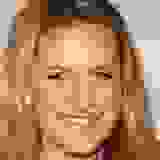
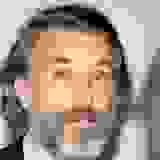
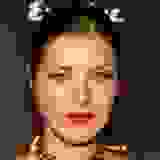
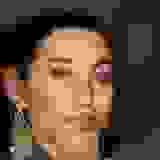
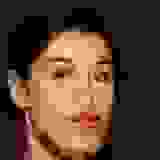
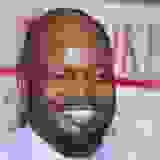
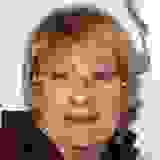
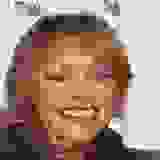
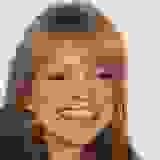
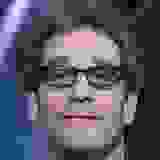
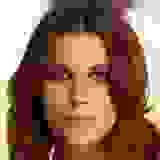
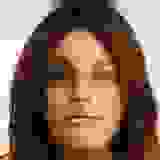
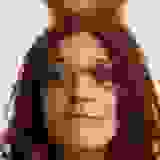
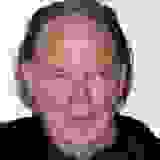
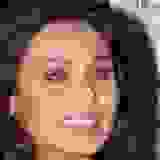
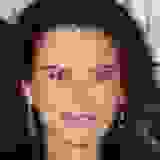
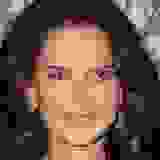
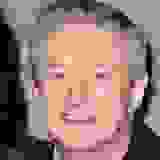
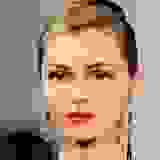
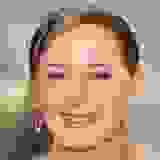
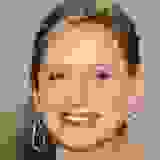
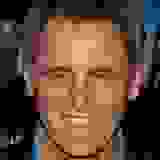
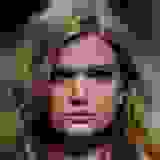
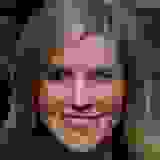
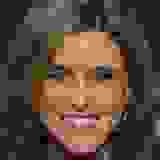
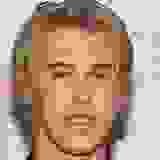
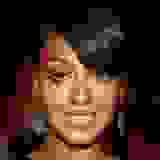
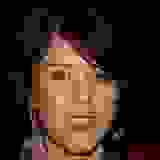
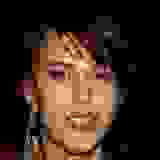
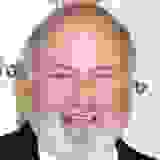
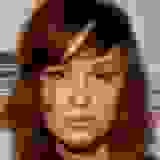
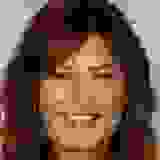
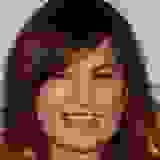
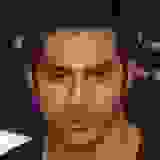
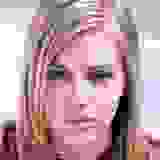
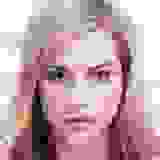
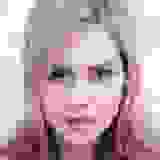
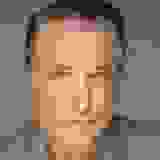
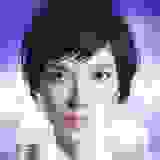
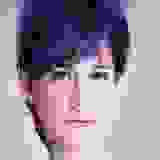
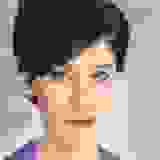
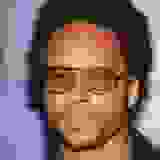
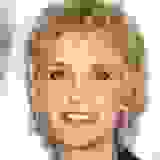
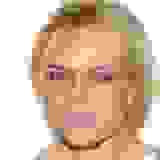
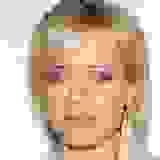
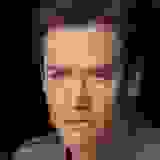
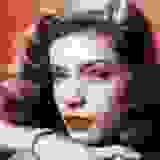
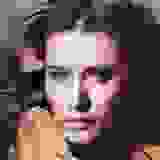
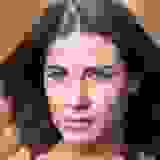
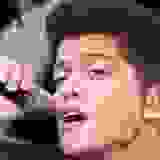
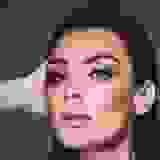
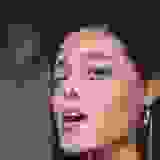
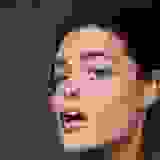
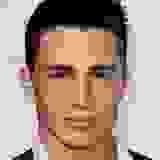
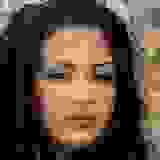
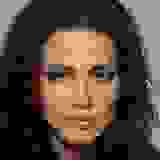
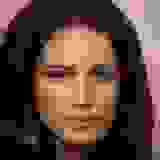
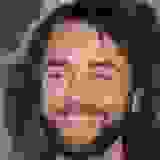
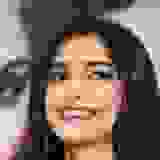
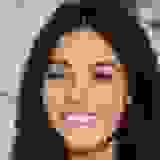
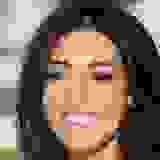
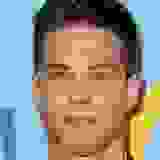
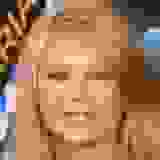
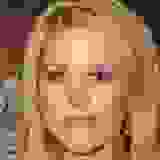
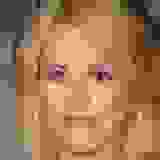
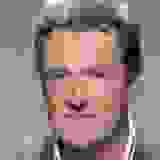
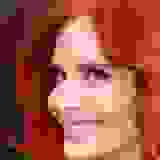
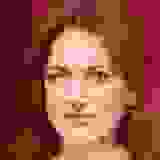
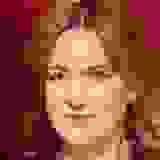
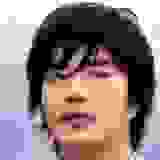
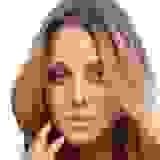
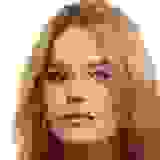
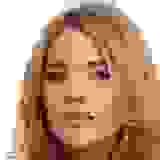
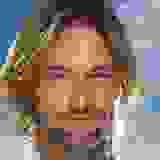
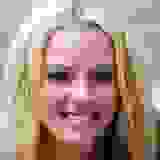
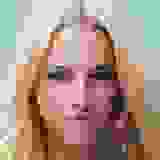
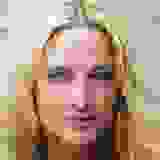
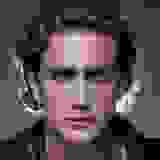
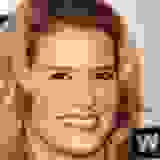
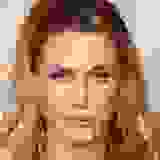
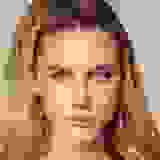
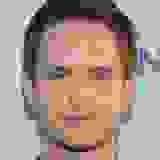
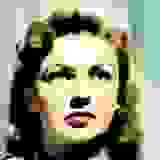
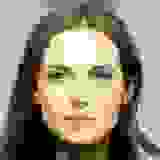
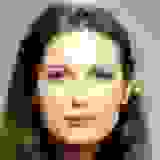
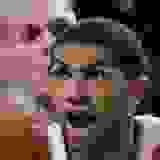
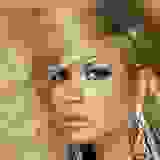
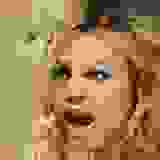
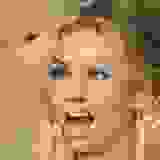
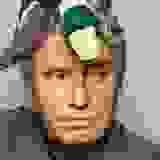
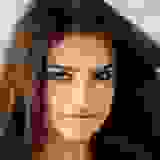
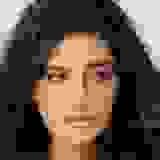
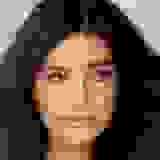
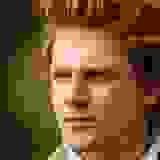
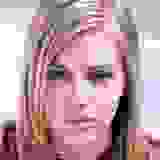
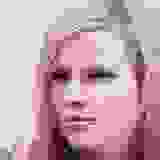
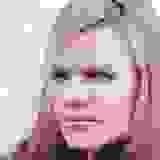
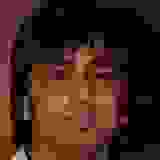
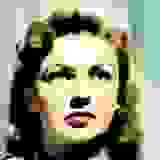
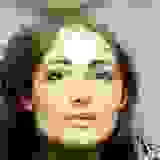
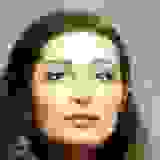
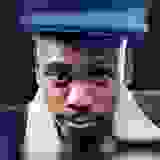
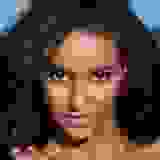
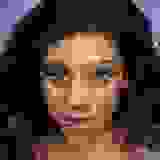
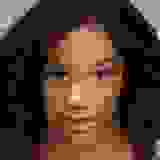
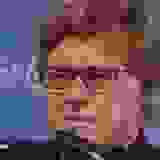
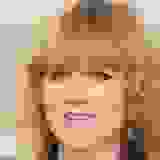
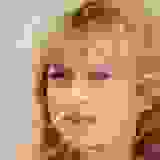
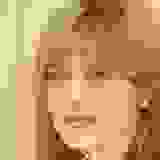
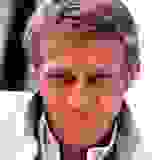
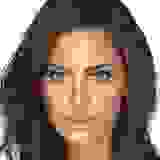
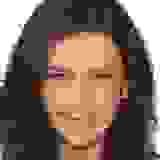
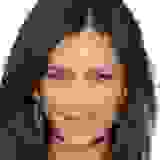
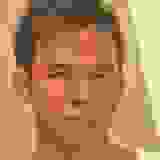
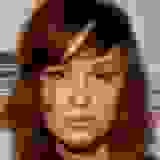
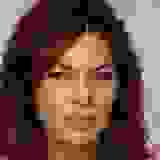
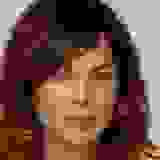
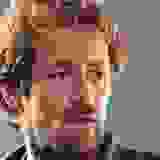
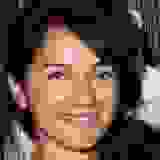
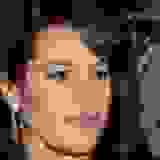
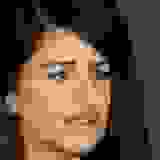
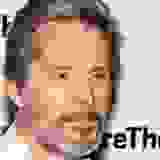
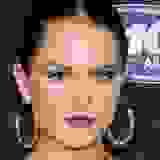
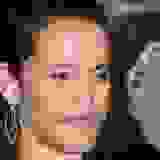
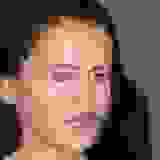
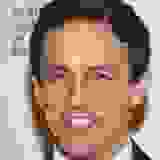
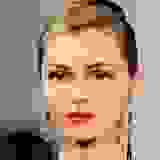
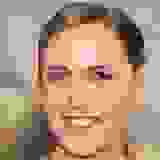
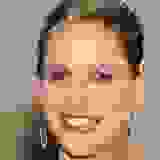
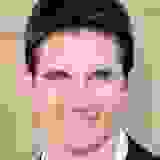
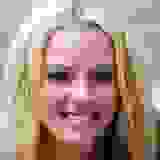
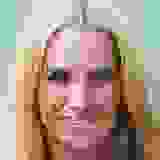
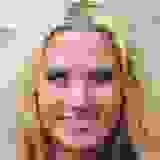
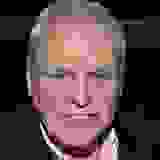
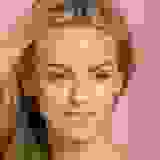
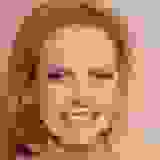
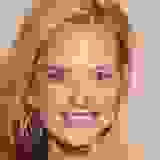
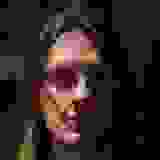
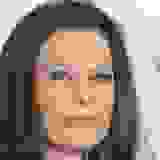
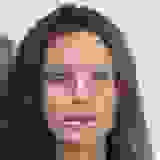
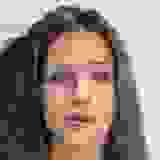
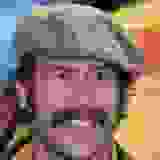
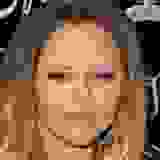
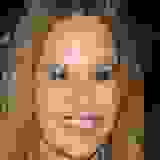
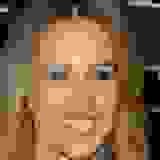
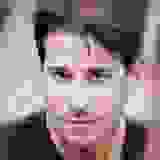
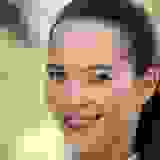
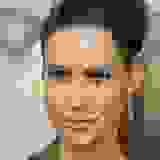
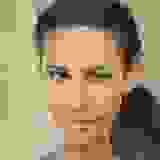
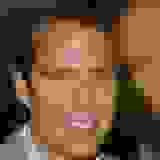
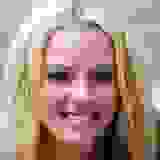
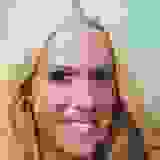
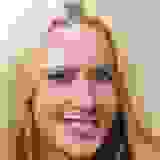
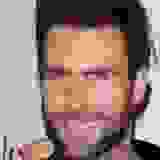
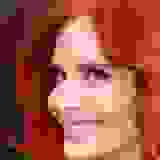
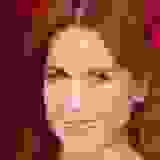
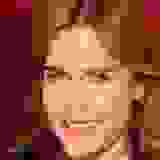
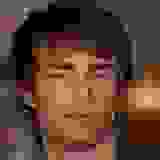
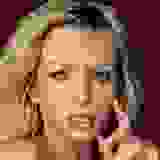
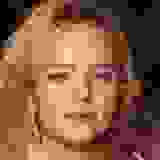
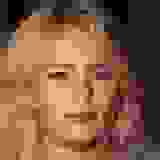
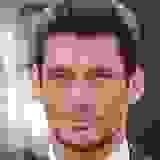
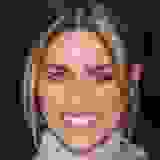
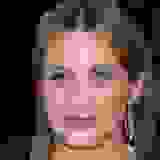
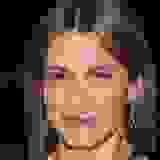
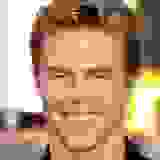
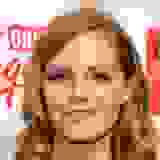
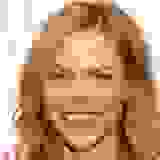
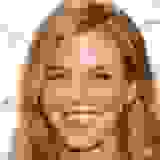
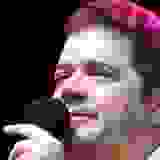
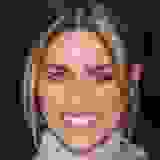
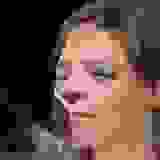
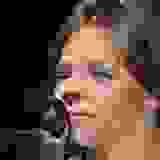
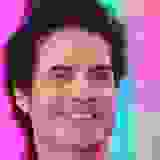
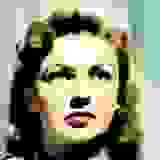
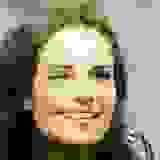
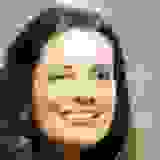
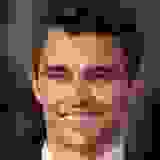
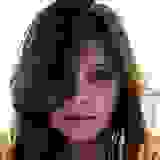
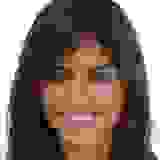
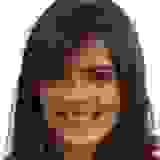
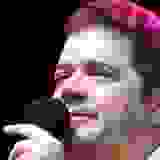
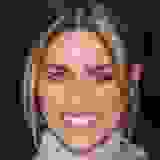
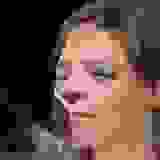
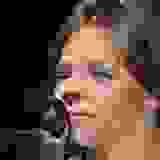
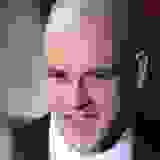
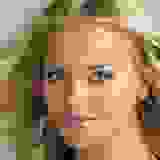
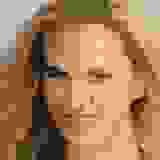
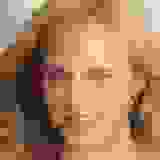
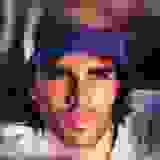
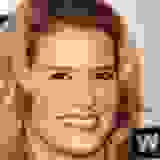
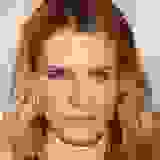
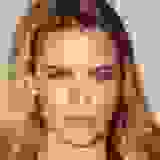
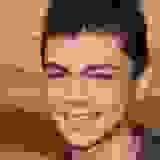
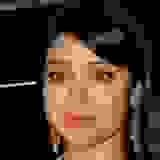
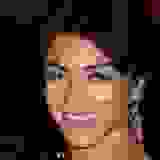
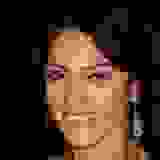
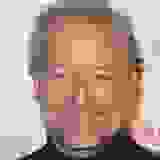
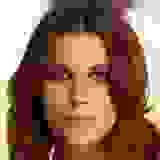
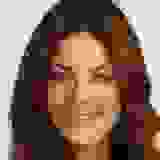
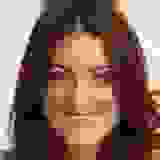
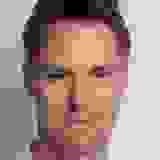
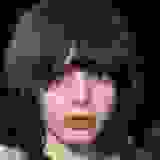
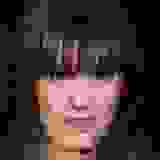
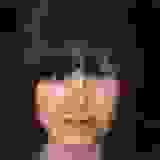
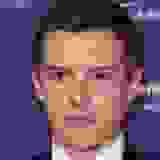
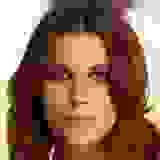
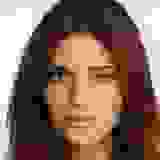
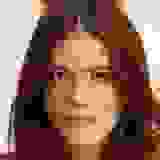
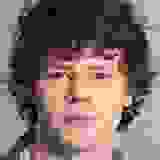
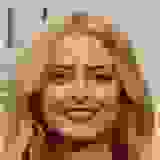
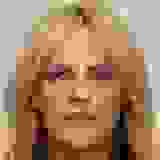
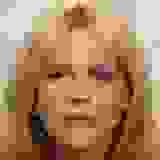
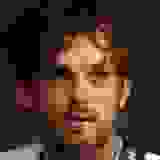
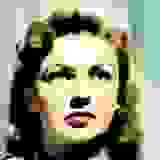
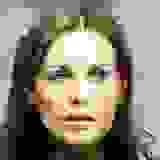
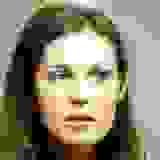
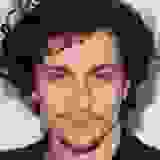
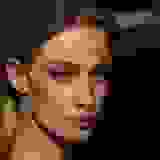
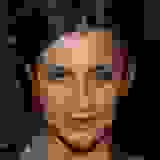
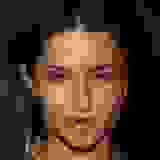
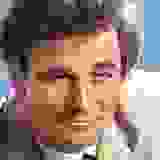
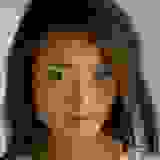
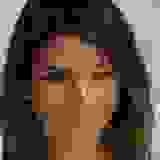
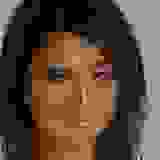
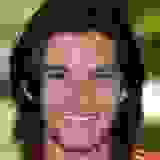
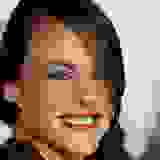
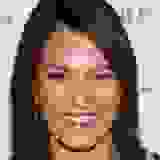
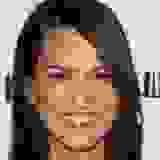
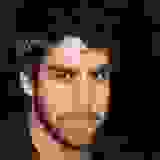
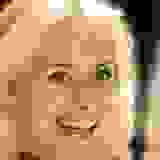
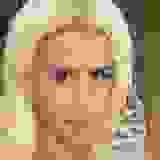
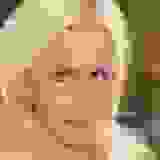
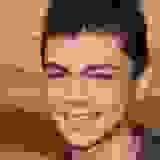
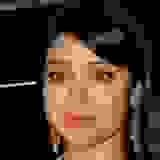
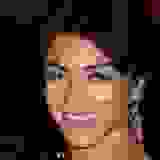
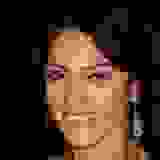
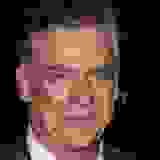
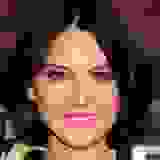
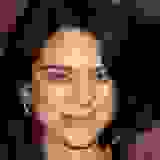
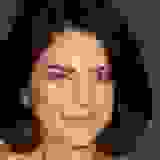
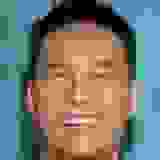
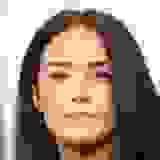
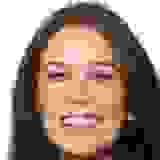
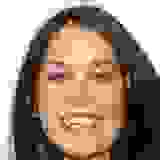
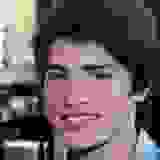
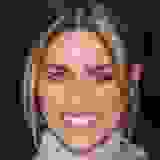
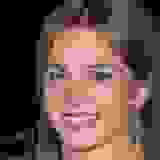
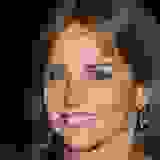
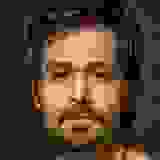
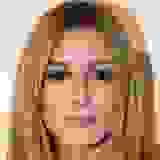
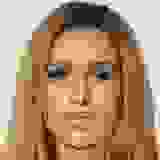
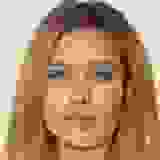
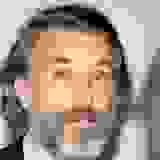
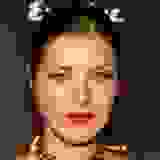
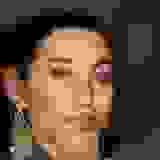
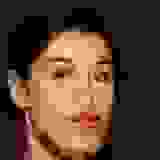
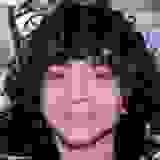
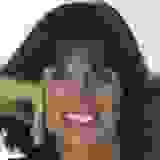
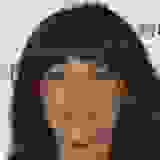
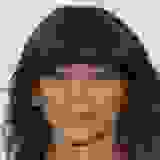
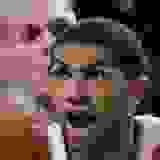
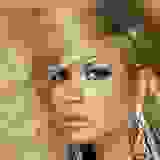
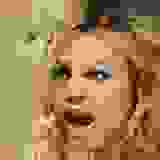
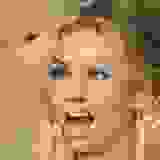
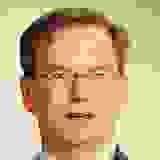
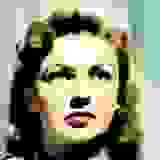
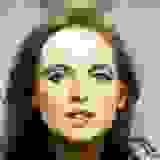
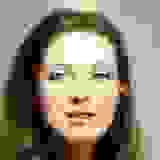
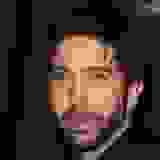
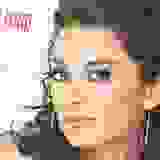
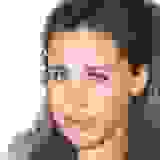
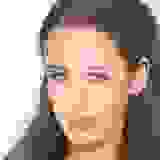
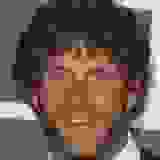
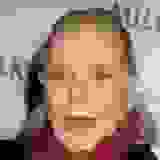
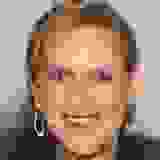
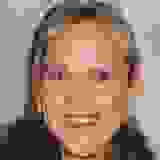
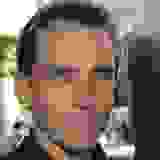
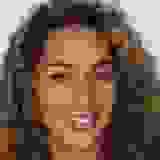
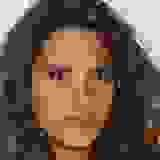
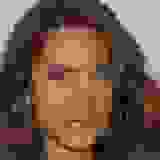
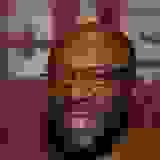
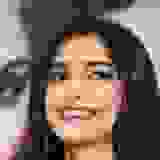
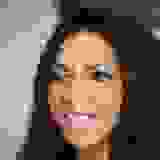
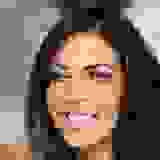
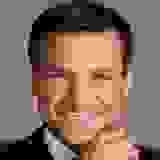
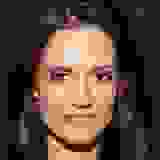
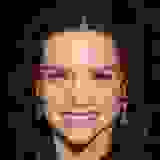
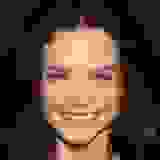
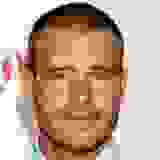
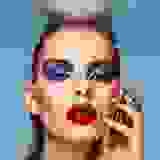
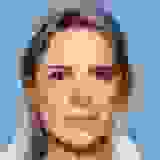
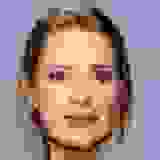
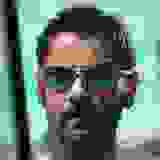
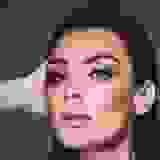
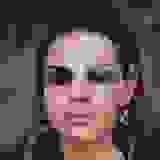
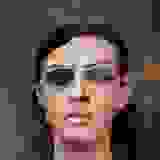
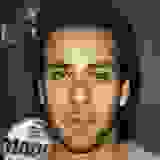
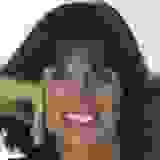
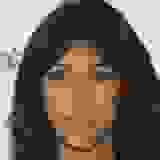
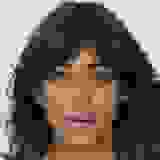
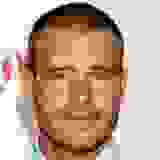
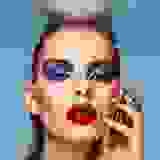
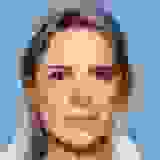
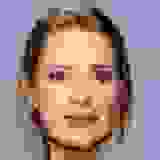
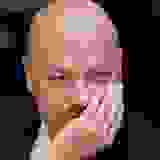
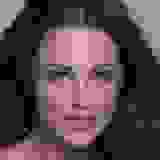
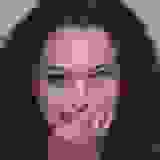
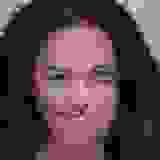
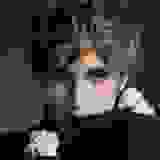
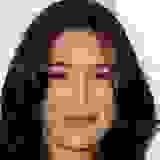
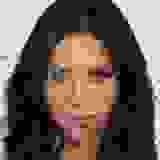
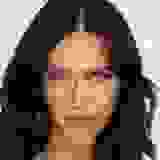
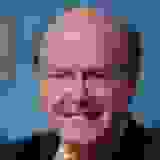
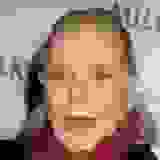
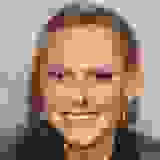
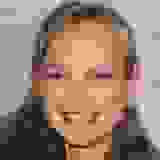
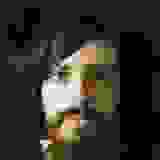
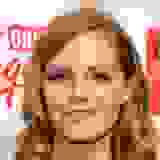
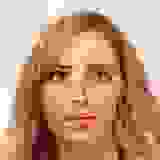
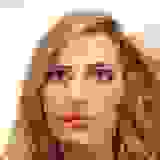
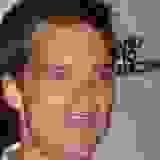
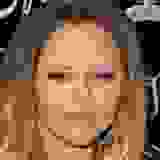
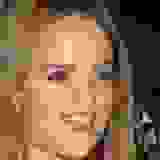
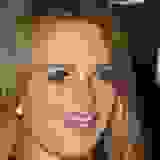
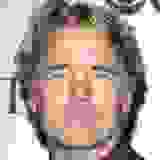
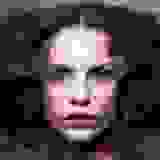
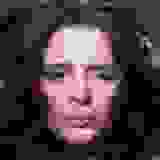
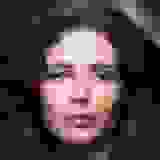
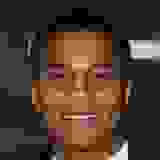
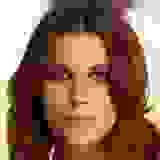
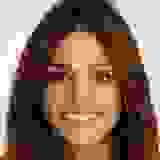
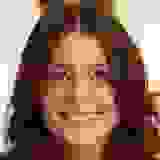
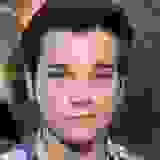
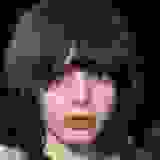
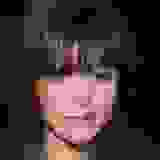
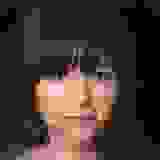
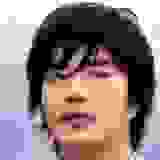
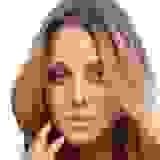
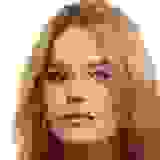
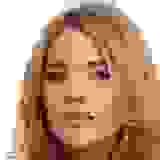
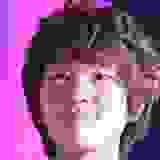
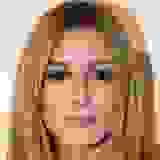
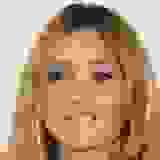
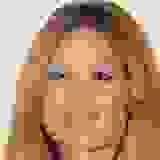
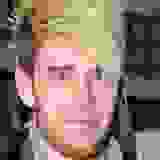
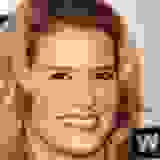
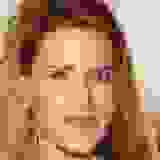
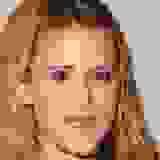
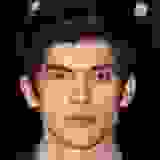
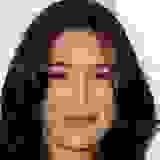
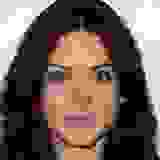
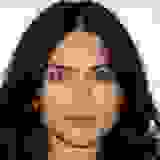
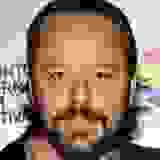
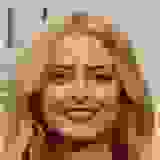
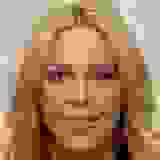
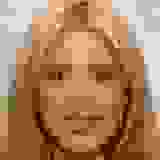
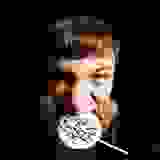
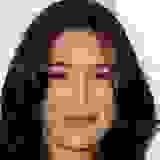
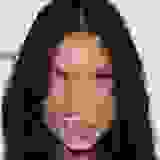
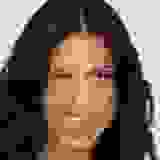
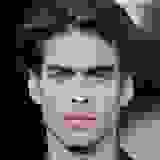
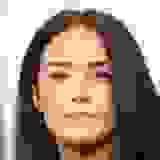
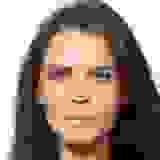
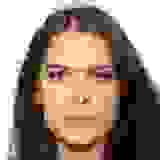
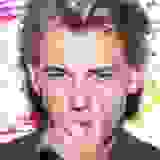
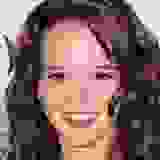
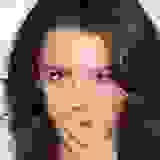
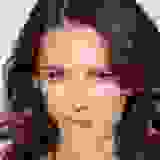
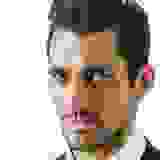
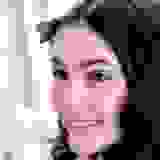
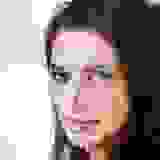
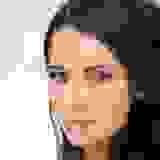
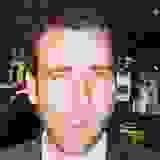
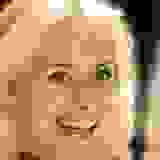
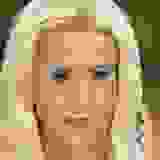
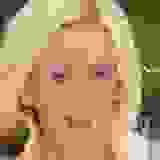
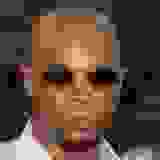
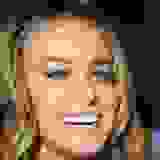
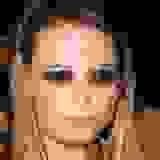
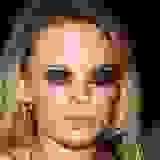
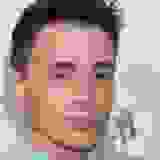
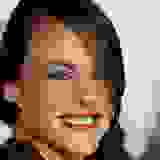
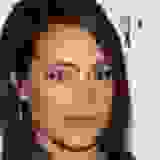
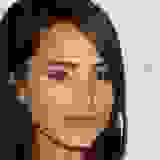
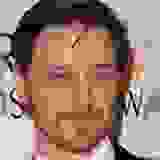
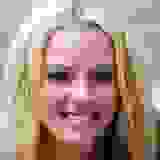
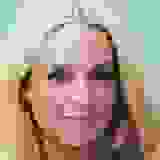
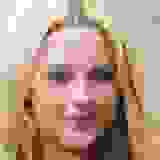
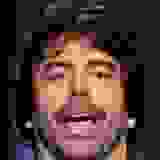
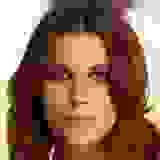
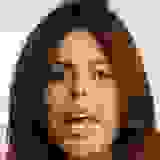
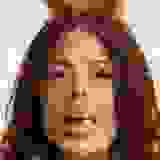
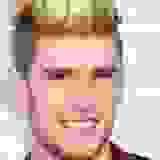
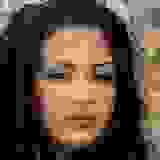
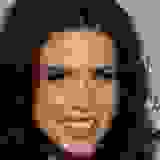
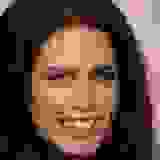
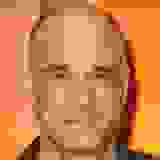
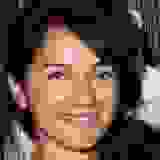
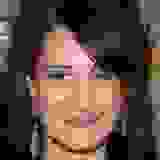
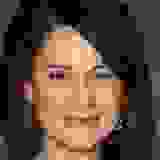
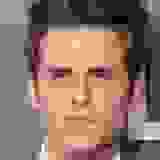
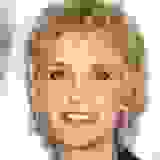
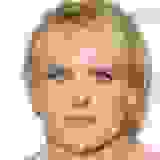
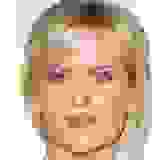
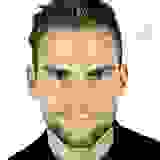
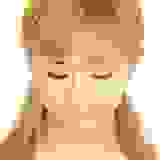
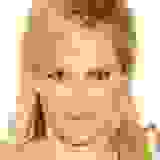
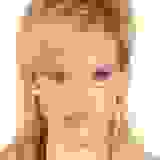
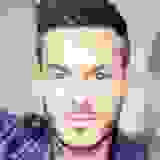
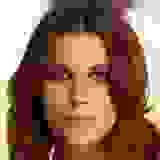
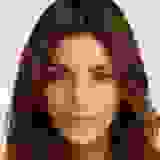
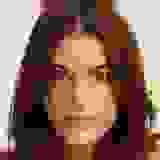
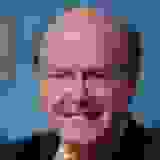
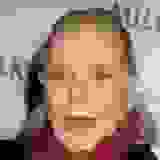
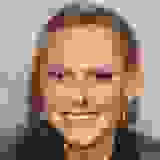
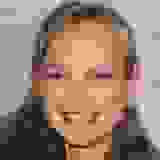
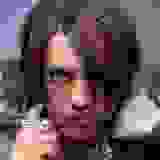
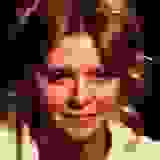
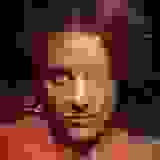
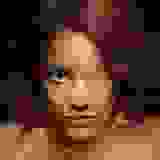
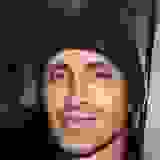
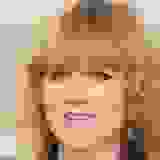
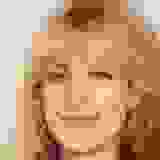
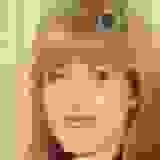
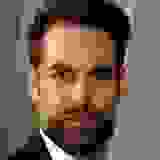
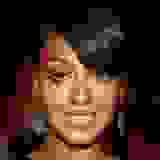
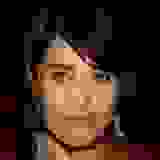
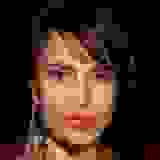
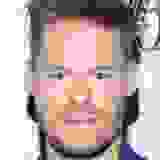
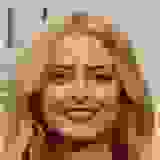
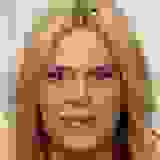
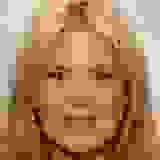
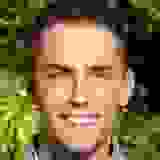
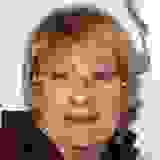
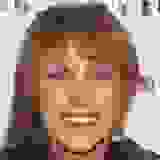
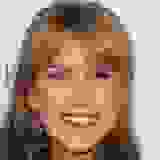
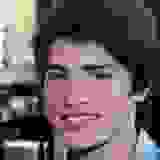
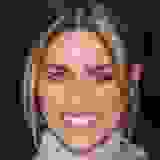
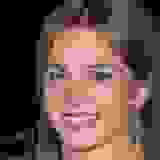
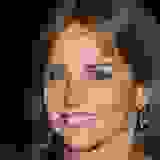
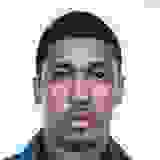
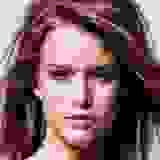
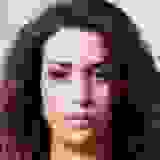
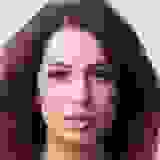
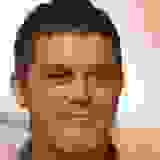
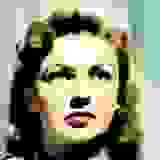
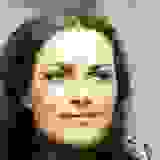
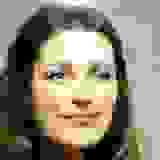
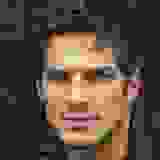
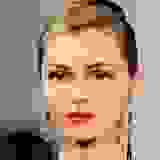
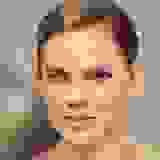
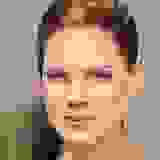
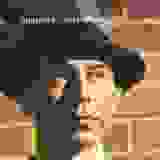
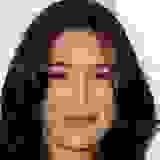
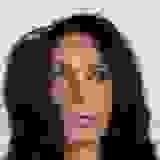
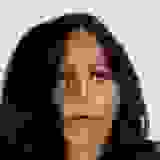
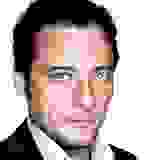
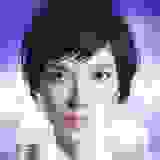
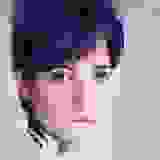
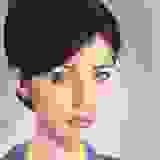
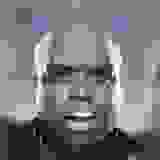
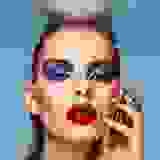
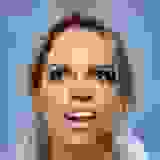
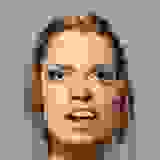
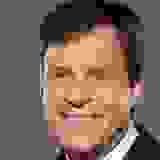
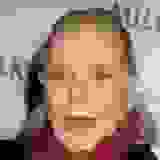
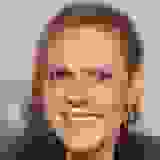
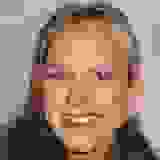
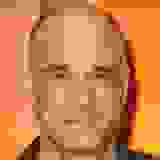
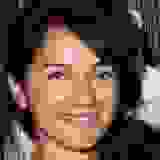
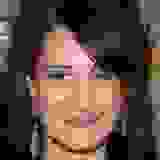
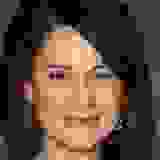
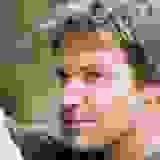
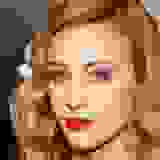
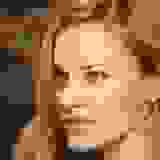
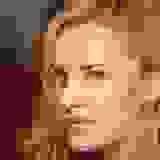
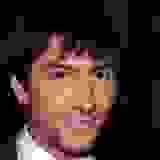
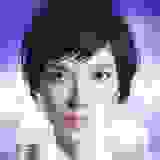
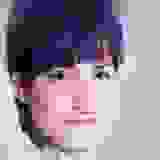
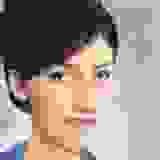
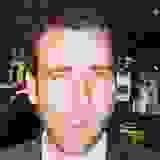
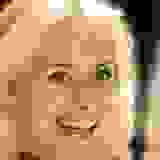
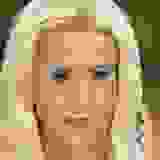
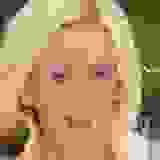
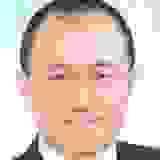
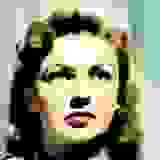
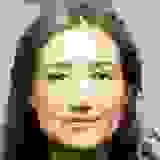
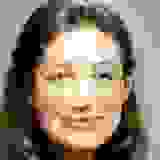
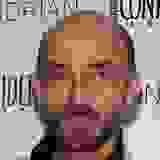
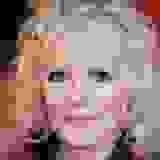
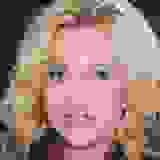
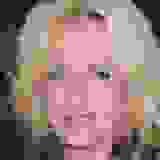
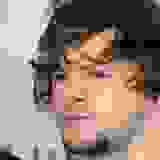
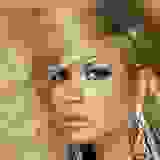
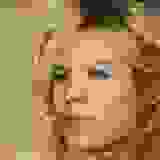
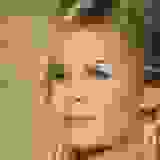
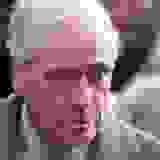
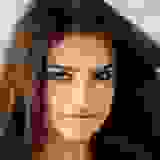
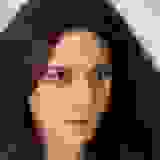
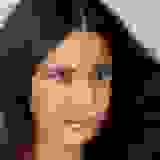
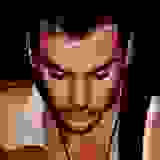
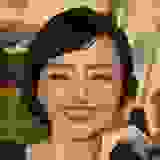
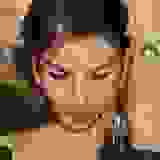
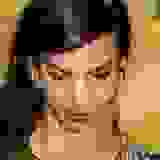
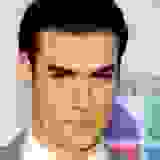
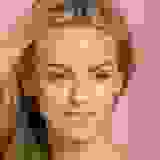
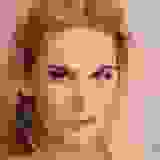
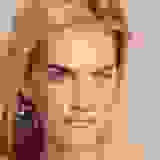
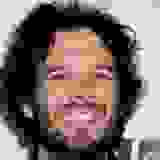
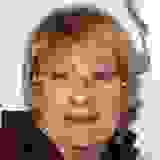
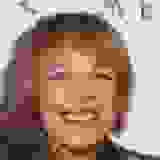
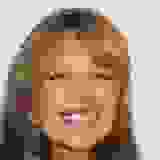
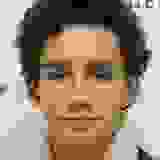
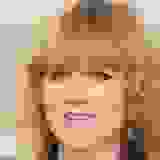
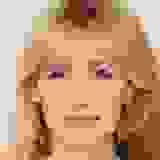
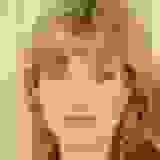
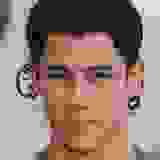
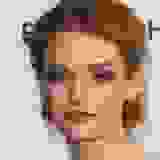
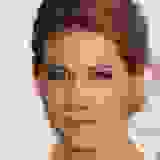
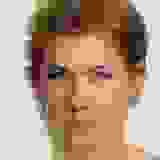
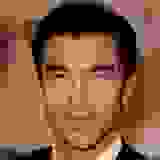
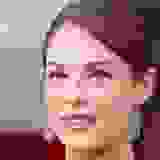
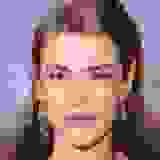
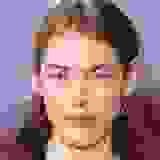
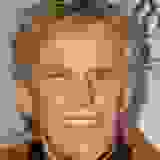
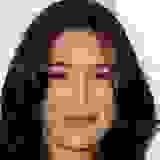
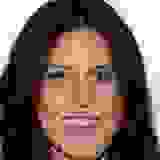
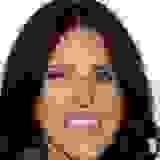
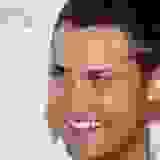
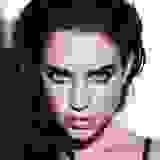
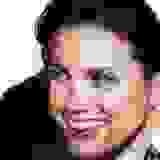
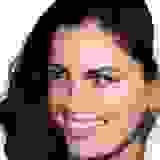
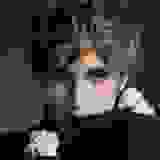
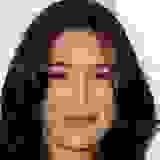
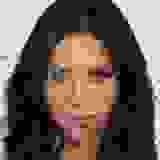
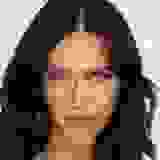
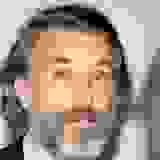
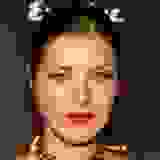
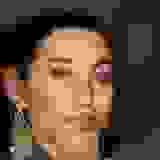
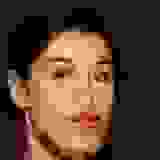
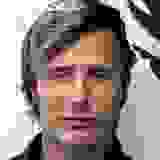
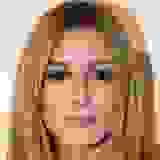
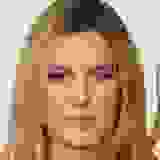
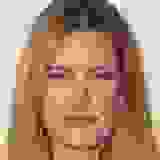

In [ ]:
male_df['base_image'] = male_df.base_path.map(lambda f: get_thumbnail(f))
male_df['our_image'] = male_df.our_path.map(lambda f: get_thumbnail(f))

new_order = [
             'index', 'path', 'src_y', 'tar_y', 'pitch', 'roll', 
             'yaw', 'ref_path', 'our_path', 'base_path','src_image', 
             'ref_image', 'our_image', 'base_image']

df = male_df.loc[:, new_order]

HTML(df.to_html(
    formatters={
        'src_image': image_formatter,
        'ref_image': image_formatter,
        'base_image': image_formatter,
        'our_image': image_formatter
        }, 
    escape=False))

#Init face detector

In [ ]:
mtcnn = MTCNN(
    image_size=244, margin=0, min_face_size=20, 
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=False, device='cuda')

resnet = InceptionResnetV1(pretrained='vggface2').eval()


#Remove undetected face

In [ ]:
undected_indexs = []

for index, row in df.iterrows():
  im = Image.open(row.path)
  im = im.resize((256,256))
  detected = mtcnn.detect(im)[0]
  if detected is None:
    undected_indexs.append(index)

for index, row in df.iterrows():
  im = Image.open(row.our_path)
  im = im.resize((256,256))
  detected = mtcnn.detect(im)[0]
  if detected is None:
    undected_indexs.append(index)

undected_indexs = list(set(undected_indexs))

for index in undected_indexs:
  print('drop row:', index)
  df.drop(index=index, axis=0, inplace=True)

drop row: 43
drop row: 165
drop row: 62


#Calculate distance

In [ ]:
def cal_l1(path1, path2):
  im1 = Image.open(path1)
  im1 = im1.resize((256,256))
  im2 = Image.open(path2)
  croped_im = mtcnn([im1,im2])
  stack = torch.stack(croped_im)
  vstack = resnet(stack).detach()
  ori_l1 = torch.linalg.norm(vstack[0] - vstack[1], 1, -1).item()
  return ori_l1


In [ ]:
df.columns

Index(['index', 'path', 'src_y', 'tar_y', 'pitch', 'roll', 'yaw', 'ref_path',
       'our_path', 'base_path', 'src_image', 'ref_image', 'our_image',
       'base_image'],
      dtype='object')

In [ ]:
distances = []
for index, row in df.iterrows():
  distances.append(cal_l1(row.path, row.our_path))

df['our_l1'] = pd.Series(distances, index=df.index)

/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  boxes = np.array(boxes)
/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndar

In [ ]:
distances = []
for index, row in df.iterrows():
  distances.append(cal_l1(row.path, row.base_path))

df['base_l1'] = pd.Series(distances, index=df.index)

/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  boxes = np.array(boxes)
/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndar

TypeError: ignored

In [ ]:
df['l1'] = 1 - df['our_l1'] / df['base_l1']

In [ ]:
df.describe()

In [ ]:

HTML(df.to_html(
    formatters={
        'src_image': image_formatter,
        'ref_image': image_formatter,
        'base_image': image_formatter,
        'our_image': image_formatter
        }, 
    escape=False))

In [ ]:
df.describe()

In [ ]:
df[df['l1'] < 0].shape

In [ ]:
df[df['l1'] > 0].describe()